In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy
import scipy
from scipy.fft import fft, rfft, fftshift,rfft2, fftfreq, rfftfreq
import jax
from scipy.special import jv
from matplotlib.image import NonUniformImage
import matplotlib
import sncosmo
from astropy.cosmology import Planck18 as cosmo
import astropy.units as units

In [3]:
ls = ['-','--','-.',(5, (10, 3)), (0, (3, 5, 1, 5, 1, 5)),':']

In [4]:
wavegrid = numpy.load("WaveGrid.npy")
flux = numpy.load("Phase0Flux.npy")
Q = numpy.load('Phase0Q.npy')
Q = Q / 1e39
flux=flux/1e39
flux_int= flux.sum(axis=(1,2))

779127.5444608831
0.3942


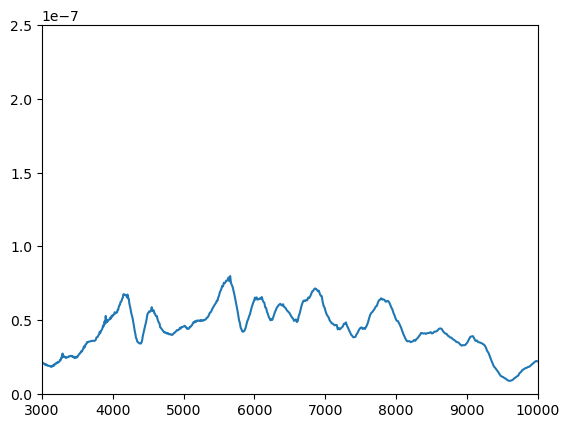

In [10]:
lambdas = numpy.flip(wavegrid)
spectrum = sncosmo.Spectrum(lambdas, numpy.flip(flux_int))
spectrum_mag = spectrum.bandmag('bessellb', magsys='vega')
flux_int = flux_int * 10**((spectrum_mag-12)/2.5) # now in units of  (erg / s / cm^2 / A) for B=12 mag
# want  dΓ/dν = AFv/(hν0).
# 
# spectrum = sncosmo.Spectrum(lambdas, flux_int) # now in units of  (erg / s / cm^2 / A) for B=12 mag
Area = 88 * 100 * 100. # cm^2
Area = numpy.pi*(9.96/2)**2*1e4
print(Area)
eff = 0.73*.9*.6
print(eff)
Area=Area*eff
h = 6.626* 10**(-34+7)  # erg s
c = 3e10 # cm/s
lcm = wavegrid/1e8  # cm
dGammadnu = Area * flux_int * wavegrid  / h /c/c*lcm*lcm
plt.plot(lambdas,dGammadnu)
plt.ylim((0,2.5e-7))
plt.xlim((3000,10000))
sigma_t =13*10**-12

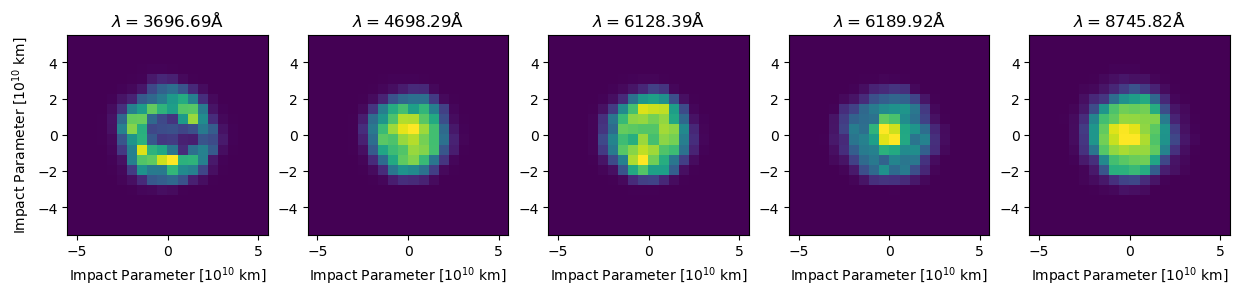

In [4]:
wls = [5850,6055,6128,6189,6355.12]
# wls = [3700, 4700, 6055, 6355,8750]
wls = [3700, 4700, 6128, 6189,8750]
idxs = [ numpy.abs(wavegrid - l).argmin() for l in wls]
fig,axs = plt.subplots(1,5, figsize=(15, 3))
for i, idx in enumerate(idxs):
    axs[i].imshow(flux[idx,:,:],extent=[-32000*3600*24*20/1e10, 32000*3600*24*20/1e10,-32000*3600*24*20/1e10, 32000*3600*24*20/1e10])
    axs[i].set_title(r'$\lambda={:.2f}$Å'.format(wavegrid[idx]))
    axs[i].set_xlabel(r"Impact Parameter [$10^{10}~\text{km}$]")
    if i==0:
        axs[i].set_ylabel(r"Impact Parameter [$10^{10}~\text{km}$]")
plt.savefig('image.pdf')

/var/folders/hr/9sdqv6450z16rzwk76fgsygw0000gn/T/ipykernel_2829/571000790.py:39: RuntimeWarning: invalid value encountered in divide
  airy = (2*jv(1,x_airy)/x_airy)**2


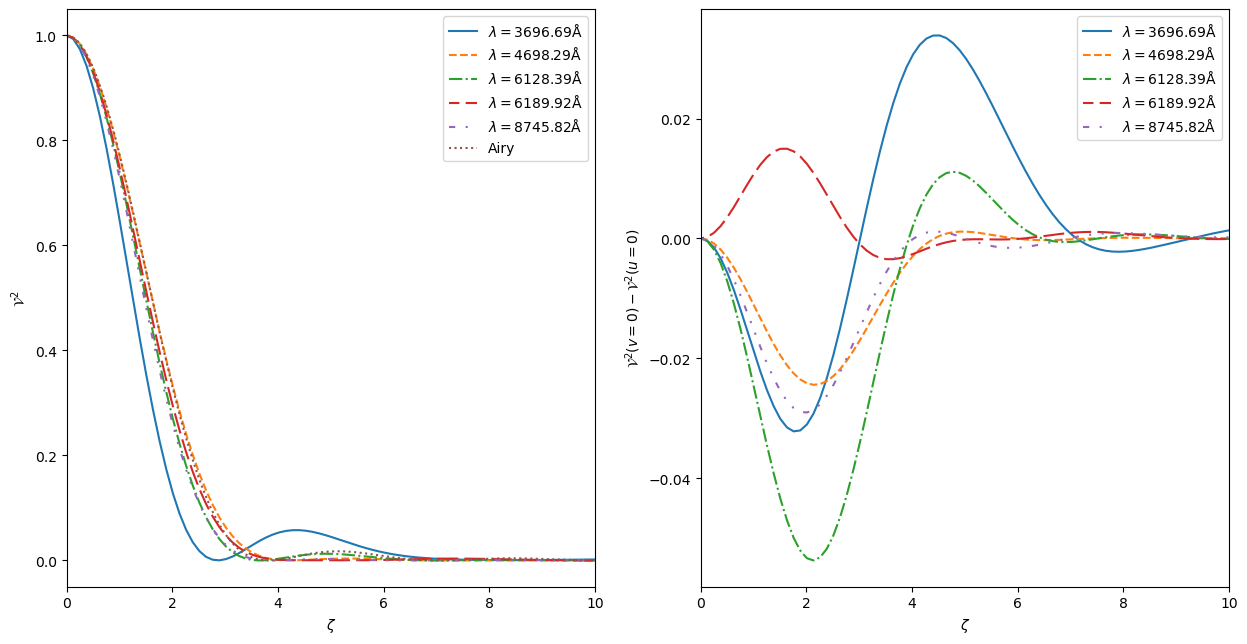

In [5]:
factor = 10
fluxshape = flux[0,:,:].shape
paddedarray = numpy.zeros((fluxshape[0]*factor, fluxshape[1]*factor))
# fig,axs = plt.subplots(1,5, figsize=(15, 3))
fig,axs = plt.subplots(1,2, figsize=(15, 7.5))
wls = [3700, 4700, 6128, 6189,8750]
idxs = [ numpy.abs(wavegrid - l).argmin() for l in wls]
for i, idx in enumerate(idxs):
    flux_norm = flux[idx,:,:]
    flux_norm = flux_norm/flux_norm.sum()
    paddedarray[0:fluxshape[0], 0:fluxshape[1]]= flux_norm
    # print(flux_norm)
    # axs[i].imshow(paddedarray)
    gamma = jax.numpy.fft.fft2(paddedarray)
    # gamma = jax.numpy.fft.rfft2(flux[idx,:,:])

    gamma = jax.numpy.absolute(gamma)
    gamma2 = gamma*gamma
    gamma2_shift = numpy.fft.fftshift(gamma2)
    x = numpy.arange(gamma2.shape[0])-gamma2.shape[0]//2
    # axs.plot(x*numpy.pi/25,gamma2_shift[gamma2.shape[0]//2,:]) #,label=r'$u=0$')
    axs[0].plot(x*numpy.pi/25, gamma2_shift[:,gamma2.shape[0]//2],label=r'$\lambda={:.2f}$Å'.format(wavegrid[idx]),lw=1.5,ls=ls[i])
    axs[1].plot(x*numpy.pi/25, gamma2_shift[:,gamma2.shape[0]//2] - gamma2_shift[gamma2.shape[0]//2,:],label=r'$\lambda={:.2f}$Å'.format(wavegrid[idx]),lw=1.5,ls=ls[i])
# axs.set_title(r'$\lambda={:.2f}\AA$'.format(wavegrid[idx]))

    # axs[i].plot(x*numpy.pi/25,gamma2_shift[gamma2.shape[0]//2,:],label=r'$u=0$')
    # axs[i].plot(x*numpy.pi/25, gamma2_shift[:,gamma2.shape[0]//2],label=r'$v=0$')
    # axs[i].set_xlim((-10,10))
    # axs[i].set_title(r'$\lambda={:.2f}\AA$'.format(wavegrid[idx]))
    # x_airy = numpy.linspace(-10.,10.,1001)
    # airy = (2*jv(1,x_airy)/x_airy)**2
    # axs[i].plot(x_airy,airy,label='Airy',ls='dotted',lw=2)
    # axs[i].legend()
    # print(gamma)
    # axs[i].imshow()
    # axs[i].imshow(gamma[0:fluxshape[0], 0:fluxshape[1]])
    # wef
x_airy = numpy.linspace(-10.0,10.,1001)
airy = (2*jv(1,x_airy)/x_airy)**2
axs[0].plot(x_airy,airy,label='Airy',ls='dotted',lw=1.5)
axs[0].set_xlim((0,10))
axs[0].set_xlabel(r"$\zeta$")
axs[0].set_ylabel(r"$\mathcal{V}^2$")
axs[0].legend()
axs[1].set_xlim((0,10))
axs[1].legend()
axs[1].set_xlabel(r"$\zeta$")
axs[1].set_ylabel(r"$\mathcal{V}^2(v=0)-\mathcal{V}^2(u=0)$")
plt.savefig('gamma2_sedona.pdf')

/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_21694/3874268408.py:125: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(F00rot45[ui,vi]) * Deltagamma2rot45[ui,vi]
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_21694/3874268408.py:130: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(F11rot45[ui,vi]) * Deltagamma2rot45[ui,vi])
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_21694/3874268408.py:136: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(1/Fsinv[minx:maxx,minx:maxx]),
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_21694/3874268408.py:159: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(1/Fsinv45[minx:maxx,minx:maxx]),norm='log',vmin=0.01,vmax=0.1,
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_21694/3874268408.py:125: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(F00rot45[ui,vi]) * Deltagamma2rot45[ui,vi]
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0

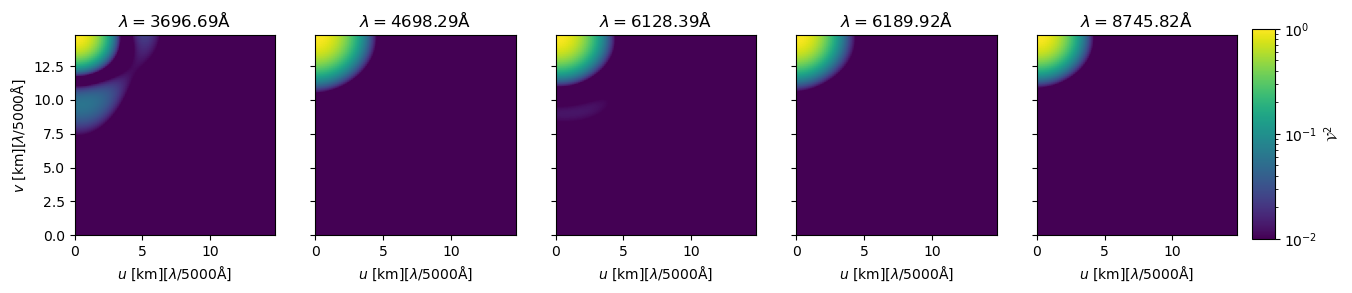

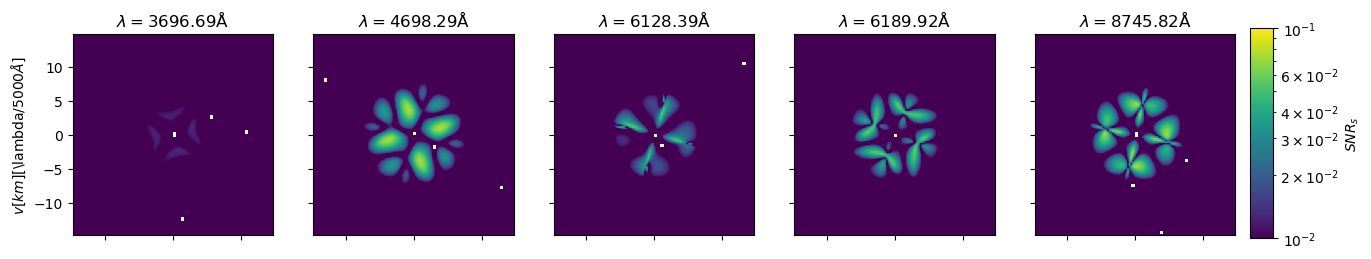

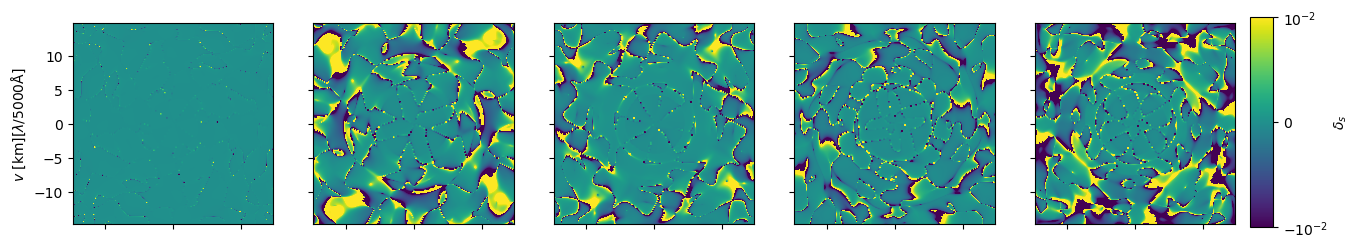

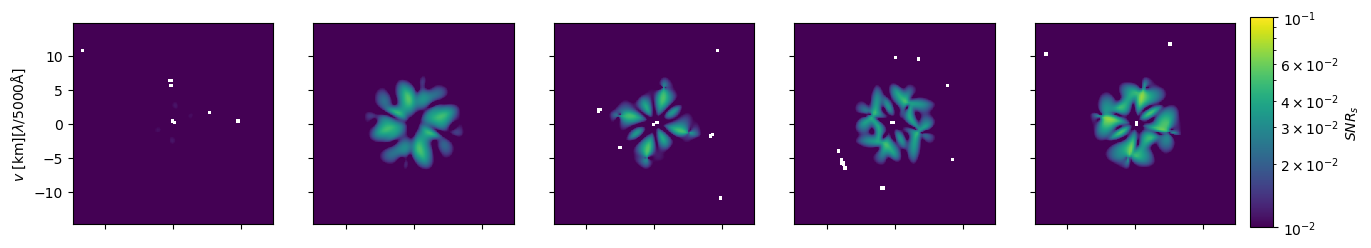

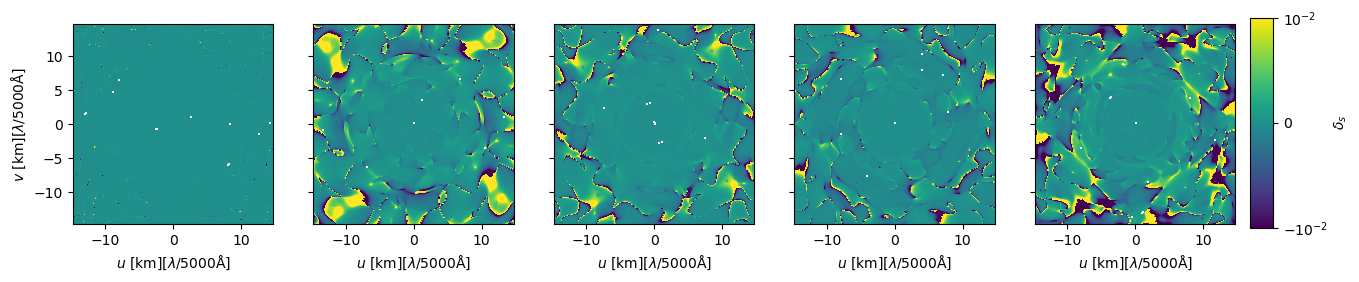

In [15]:
wls = [5850,6055,6128,6189,6355.12]
wls = [3700, 4700, 6055, 6355,8750]
wls = [3700, 4700, 6128, 6189,8750]

idxs = [ numpy.abs(wavegrid - l).argmin() for l in wls]
factor = 10

Dwidth = 2 * 32000*3600*24*20 * factor * units.km
DA = cosmo.angular_diameter_distance(0.004)
Deltau = (DA/Dwidth).decompose()*5000e-10/1000   #at 5000A km

fluxshape = flux[0,:,:].shape

paddedarray = numpy.zeros((fluxshape[0]*factor, fluxshape[1]*factor))
numpy.random.seed(42)
noisemap = numpy.random.normal(1,0.05,size=(fluxshape[0], fluxshape[1]))

# fig,axs = plt.subplots(4,5, figsize=(15, 12))
fig0,axs0 = plt.subplots(1,5, figsize=(15, 3))
fig1,axs1 = plt.subplots(1,5, figsize=(15, 3))
fig2,axs2 = plt.subplots(1,5, figsize=(15, 3))
fig3,axs3 = plt.subplots(1,5, figsize=(15, 3))
fig4,axs4 = plt.subplots(1,5, figsize=(15, 3))

# theta = numpy.arange(fluxshape[0]*factor)
theta  = [i- fluxshape[0]/2 + 0.5 for i in range(paddedarray.shape[0])]
theta = numpy.array(theta)

Fsinv = numpy.zeros((paddedarray.shape[0],paddedarray.shape[1]))
deltas = numpy.zeros((paddedarray.shape[0],paddedarray.shape[1]))
Fsinv45 = numpy.zeros((paddedarray.shape[0],paddedarray.shape[1]))
deltas45 = numpy.zeros((paddedarray.shape[0],paddedarray.shape[1]))
# Fsinv_phi = numpy.zeros((paddedarray.shape[0],paddedarray.shape[1]))
# Fsinv_s = numpy.zeros((paddedarray.shape[0],paddedarray.shape[1]))
for i, idx in enumerate(idxs):
    Fsinv[:]=0
    paddedarray[:]=0
    flux_norm = flux[idx,:,:]
    flux_norm = flux_norm/flux_norm.sum()
    paddedarray[0:fluxshape[0], 0:fluxshape[1]]= flux_norm

    gamma = jax.numpy.fft.fft2(paddedarray)


    dgammau = -2j*numpy.pi* jax.numpy.fft.fft2(paddedarray*theta[:,None])
    dgammav = -2j*numpy.pi* jax.numpy.fft.fft2(paddedarray*theta[None,:])

    dum = flux[idx,:,:]*noisemap
    dum = dum/dum.sum()
    paddedarray[0:fluxshape[0], 0:fluxshape[1]]= dum
    gamma_noise = jax.numpy.fft.fft2(paddedarray)    

    gamma2  = jax.numpy.absolute(gamma)**2
    gamma2_noise =  jax.numpy.absolute(gamma_noise)**2

    minx = paddedarray.shape[0]//2-factor//3*fluxshape[0]
    maxx = paddedarray.shape[0]//2+factor//3*fluxshape[0]

    emin = minx - (minx + maxx)/2
    emax = maxx - (minx + maxx)/2
    im0 = axs0[i].imshow(gamma2[0:fluxshape[0]*factor//2,0:fluxshape[1]*factor//2],
                         norm='log',vmin=0.01, vmax=1,extent=[0,Deltau*emax,0,Deltau*emax])
    if i ==0:
        axs0[i].set_ylabel(r'$v$ [km][$\lambda/5000$Å]')
    if i != 0:
        axs0[i].yaxis.set_ticklabels([])
    axs0[i].set_xlabel(r'$u$ [km][$\lambda/5000$Å]')
    axs0[i].set_title(r'$\lambda={:.2f}$Å'.format(wavegrid[idx]))    
    
    u=fftfreq(paddedarray.shape[0])
    v=fftfreq(paddedarray.shape[1])
    
    dgammas = -(u[:,None]*dgammau + v[None,:]*dgammav)
    dgammaphi = -v[None,:]*dgammau + u[:,None]*dgammav
    
    F00= jax.numpy.absolute(2*gamma.conjugate() * dgammas) **2
    F01= jax.numpy.absolute(2*gamma.conjugate() * dgammas)*jax.numpy.absolute(2*gamma.conjugate() * dgammaphi)
    F11 = jax.numpy.absolute(2*gamma.conjugate() * dgammaphi)**2

    gamma2 = numpy.fft.fftshift(gamma2)
    Deltagamma2 = gamma2 - numpy.fft.fftshift(gamma2_noise)

    F00 = numpy.fft.fftshift(F00)
    F01 = numpy.fft.fftshift(F01)
    F11 = numpy.fft.fftshift(F11)    

    gamma2rot = numpy.rot90(gamma2)    
    Deltagamma2rot = numpy.rot90(Deltagamma2)
    F00rot=numpy.rot90(F00)
    F01rot=numpy.rot90(F01)
    F11rot=numpy.rot90(F11)

    gamma2rot45 = numpy.pad(scipy.ndimage.rotate(scipy.ndimage.zoom(gamma2,1/numpy.sqrt(2)),45,reshape=True),((0,1),(0,1))) 
    Deltagamma2rot45 = numpy.pad(scipy.ndimage.rotate(scipy.ndimage.zoom(Deltagamma2,1/numpy.sqrt(2)),45,reshape=True),((0,1),(0,1))) 

    F00rot45 = numpy.pad(scipy.ndimage.rotate(scipy.ndimage.zoom(F00,1/numpy.sqrt(2)),45,reshape=True),((0,1),(0,1)))
    F01rot45 = numpy.pad(scipy.ndimage.rotate(scipy.ndimage.zoom(F01,1/numpy.sqrt(2)),45,reshape=True),((0,1),(0,1)))
    F11rot45 = numpy.pad(scipy.ndimage.rotate(scipy.ndimage.zoom(F11,1/numpy.sqrt(2)),45,reshape=True),((0,1),(0,1)))
    
    siginv = dGammadnu[idx] * (128*numpy.pi)**(-0.25) * numpy.sqrt(3600/sigma_t)
    
    for ui in range(0,Fsinv.shape[0]):
        for vi in range(0,Fsinv.shape[1]):
            if ui==0 and vi==0:
                continue
            try:
                Finv = numpy.linalg.inv([[F00[ui,vi]+F00rot[ui,vi],F01[ui,vi]+F01rot[ui,vi]],[F01[ui,vi]+F01rot[ui,vi],F11[ui,vi]+F11rot[ui,vi]]])
                Fsinv[ui,vi] = Finv[0,0]
                deltas[ui,vi] = (Finv[0,0]* siginv**2 /2 *
                                    (numpy.sqrt(F00[ui,vi]) * Deltagamma2[ui,vi] +
                                     numpy.sqrt(F00rot[ui,vi]) * Deltagamma2rot[ui,vi]
                                    ) + 
                                Finv[0,1]* siginv**2 /2 *
                                     (numpy.sqrt(F11[ui,vi]) * Deltagamma2[ui,vi] +
                                     numpy.sqrt(F11rot[ui,vi]) * Deltagamma2rot[ui,vi])
                                 )
                Finv = numpy.linalg.inv(
                    [[F00[ui,vi]+F00rot[ui,vi]+F00rot45[ui,vi],F01[ui,vi]+F01rot[ui,vi]+F01rot45[ui,vi]],
                     [F01[ui,vi]+F01rot[ui,vi]+F01rot45[ui,vi],F11[ui,vi]+F11rot[ui,vi]+F11rot45[ui,vi]]]
                     )
                Fsinv45[ui,vi] = Finv[0,0]
                deltas45[ui,vi] = (Finv[0,0]* siginv**2 /3 *
                                    (numpy.sqrt(F00[ui,vi]) * Deltagamma2[ui,vi] +
                                     numpy.sqrt(F00rot[ui,vi]) * Deltagamma2rot[ui,vi] +
                                     numpy.sqrt(F00rot45[ui,vi]) * Deltagamma2rot45[ui,vi] 
                                    ) + 
                                Finv[0,1]* siginv**2 /3 *
                                     (numpy.sqrt(F11[ui,vi]) * Deltagamma2[ui,vi] +
                                     numpy.sqrt(F11rot[ui,vi]) * Deltagamma2rot[ui,vi] +
                                     numpy.sqrt(F11rot45[ui,vi]) * Deltagamma2rot45[ui,vi])
                                 )
            except:
                pass

    im1 = axs1[i].imshow(siginv /2 *
                         numpy.sqrt(1/Fsinv[minx:maxx,minx:maxx]),
                         norm='log',vmin=0.01,vmax=0.1,extent=[emin*Deltau,emax*Deltau,emin*Deltau,emax*Deltau])
    
    if i ==0:
        axs1[i].set_ylabel(r'$v [km][$\lambda/5000$Å]$')
    # axs1[i].set_xlabel(r'$u$ [km][$\lambda/5000\AA$]')
    axs1[i].xaxis.set_ticklabels([])
    if i != 0:
        axs1[i].yaxis.set_ticklabels([])
    axs1[i].set_title(r'$\lambda={:.2f}$Å'.format(wavegrid[idx]))

    im2 = axs2[i].imshow(deltas,norm=matplotlib.colors.SymLogNorm(linthresh=0.03, linscale=0.03,
                                              vmin=-0.01, vmax=0.01, base=10),
                         extent=[emin*Deltau,emax*Deltau,emin*Deltau,emax*Deltau])
    if i ==0:
        axs2[i].set_ylabel(r'$v$ [km][$\lambda/5000$Å]')
    # axs2[i].set_xlabel(r'$u$ [km][$\lambda/5000\AA$]')
    axs2[i].xaxis.set_ticklabels([])
    if i != 0:
        axs2[i].yaxis.set_ticklabels([])
    # axs[2,i].set_title(r'$\lambda={:.2f}\AA$'.format(wavegrid[idx]))
    
    im3 = axs3[i].imshow(siginv /3 *
                        numpy.sqrt(1/Fsinv45[minx:maxx,minx:maxx]),norm='log',vmin=0.01,vmax=0.1,
                         extent=[emin*Deltau,emax*Deltau,emin*Deltau,emax*Deltau])

    
    if i ==0:
        axs3[i].set_ylabel(r'$v$ [km][$\lambda/5000$Å]')
    # axs3[i].set_xlabel(r'$u$ [km][$\lambda/5000\AA$]')
    axs3[i].xaxis.set_ticklabels([])
    if i != 0:
        axs3[i].yaxis.set_ticklabels([])
    # axs[3,i].set_title(r'$\lambda={:.2f}\AA$'.format(wavegrid[idx]))
    
    im4 = axs4[i].imshow(deltas45,norm=matplotlib.colors.SymLogNorm(linthresh=0.03, linscale=0.03,
                                              vmin=-0.01, vmax=0.01, base=10),
                         extent=[emin*Deltau,emax*Deltau,emin*Deltau,emax*Deltau])
    if i ==0:
        axs4[i].set_ylabel(r'$v$ [km][$\lambda/5000$Å]')
    axs4[i].set_xlabel(r'$u$ [km][$\lambda/5000$Å]')
    if i != 0:
        axs4[i].yaxis.set_ticklabels([])
    # axs[4,i].set_title(r'$\lambda={:.2f}\AA$'.format(wavegrid[idx]))
    


    
fig0.subplots_adjust(right=0.90)
fig1.subplots_adjust(right=0.90)
fig2.subplots_adjust(right=0.90)
fig3.subplots_adjust(right=0.90)
fig4.subplots_adjust(right=0.90)
cbar_ax = fig0.add_axes([0.91, 0.15, 0.015, 0.7])
cbar=fig0.colorbar(im0, cax=cbar_ax)
cbar.set_label(r"$\mathcal{V}^2$")
cbar_ax = fig1.add_axes([0.91, 0.15, 0.015, 0.7])
cbar=fig1.colorbar(im1, cax=cbar_ax)
cbar.set_label(r"$SNR_s$")
cbar_ax = fig2.add_axes([0.91, 0.15, 0.015, 0.7])
cbar=fig2.colorbar(im2, cax=cbar_ax)
cbar.set_label(r"$\delta_s$")
cbar_ax = fig3.add_axes([0.91, 0.15, 0.015, 0.7])
cbar=fig3.colorbar(im3, cax=cbar_ax)
cbar.set_label(r"$SNR_s$")
cbar_ax = fig4.add_axes([0.91, 0.15, 0.015, 0.7])
cbar=fig4.colorbar(im4, cax=cbar_ax)
cbar.set_label(r"$\delta_s$")

fig0.savefig('g2map_sedona.pdf')
fig2.savefig('ds_1_sedona.pdf')
fig4.savefig('ds_2_sedona.pdf')
fig1.savefig('ston_1_sedona.pdf')
fig3.savefig('ston_2_sedona.pdf')
# fig3.savefig('ston_sedona.pdf')

/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_21694/2047766556.py:121: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(F00rot45[ui,vi]) * Deltagamma2rot45[ui,vi]
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_21694/2047766556.py:126: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(F11rot45[ui,vi]) * Deltagamma2rot45[ui,vi])
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_21694/2047766556.py:145: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(1/Fsinv[minx:maxx,minx:maxx]),
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_21694/2047766556.py:168: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(1/Fsinv45[minx:maxx,minx:maxx]),norm='log',vmin=0.01,vmax=0.5,
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_21694/2047766556.py:121: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(F00rot45[ui,vi]) * Deltagamma2rot45[ui,vi]
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0

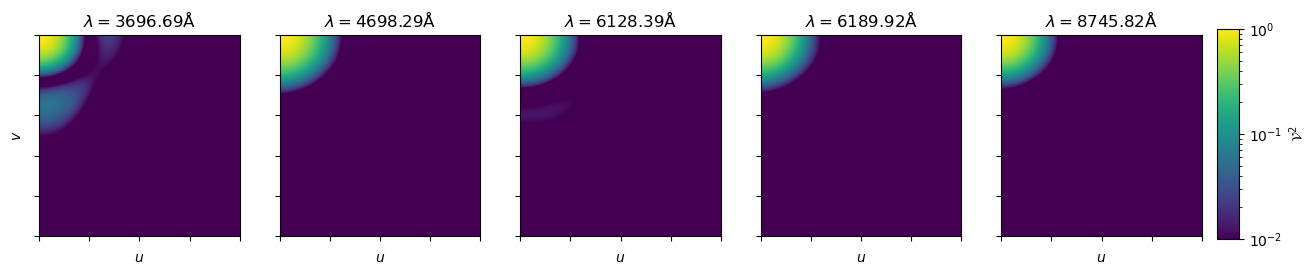

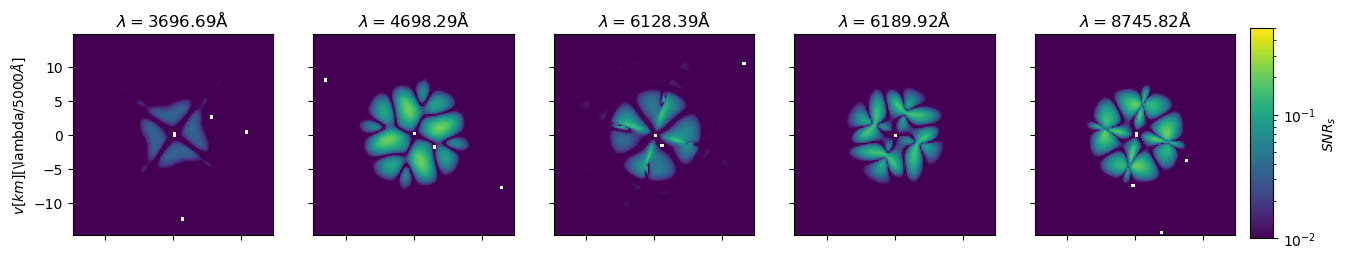

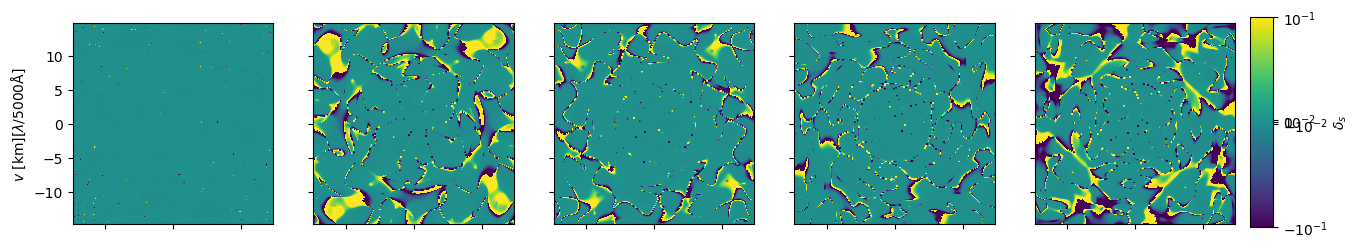

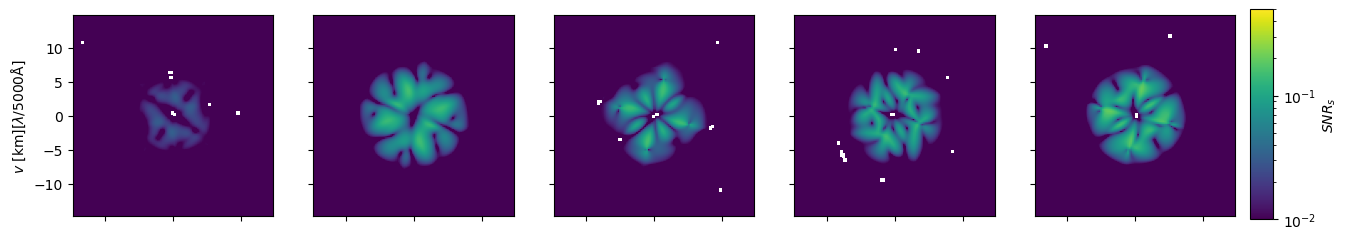

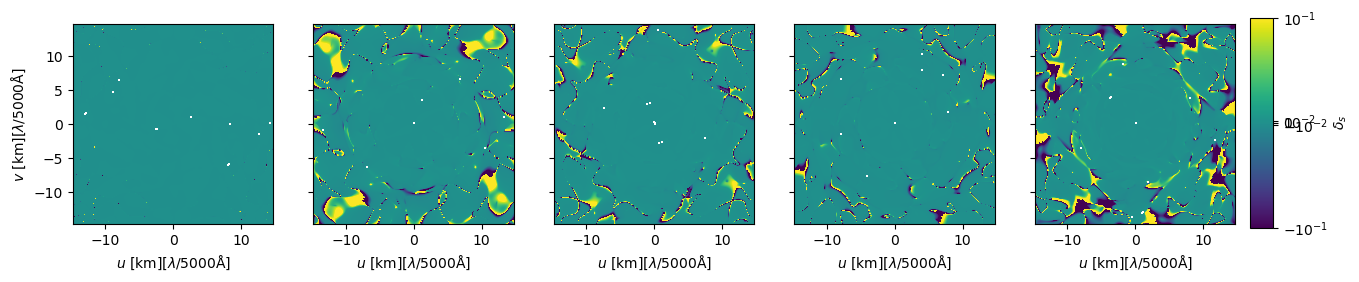

In [5]:
wls = [5850,6055,6128,6189,6355.12]
wls = [3700, 4700, 6055, 6355,8750]
wls = [3700, 4700, 6128, 6189,8750]

idxs = [ numpy.abs(wavegrid - l).argmin() for l in wls]
factor = 10

Dwidth = 2 * 32000*3600*24*20 * factor * units.km
DA = cosmo.angular_diameter_distance(0.004)
Deltau = (DA/Dwidth).decompose()*5000e-10/1000   #at 5000A km

fluxshape = flux[0,:,:].shape

paddedarray = numpy.zeros((fluxshape[0]*factor, fluxshape[1]*factor))
numpy.random.seed(42)
noisemap = numpy.random.normal(1,0.05,size=(fluxshape[0], fluxshape[1]))

# fig,axs = plt.subplots(4,5, figsize=(15, 12))
fig0,axs0 = plt.subplots(1,5, figsize=(15, 3))
fig1,axs1 = plt.subplots(1,5, figsize=(15, 3))
fig2,axs2 = plt.subplots(1,5, figsize=(15, 3))
fig3,axs3 = plt.subplots(1,5, figsize=(15, 3))
fig4,axs4 = plt.subplots(1,5, figsize=(15, 3))

# theta = numpy.arange(fluxshape[0]*factor)
theta  = [i- fluxshape[0]/2 + 0.5 for i in range(paddedarray.shape[0])]
theta = numpy.array(theta)

Fsinv = numpy.zeros((paddedarray.shape[0],paddedarray.shape[1]))
deltas = numpy.zeros((paddedarray.shape[0],paddedarray.shape[1]))
Fsinv45 = numpy.zeros((paddedarray.shape[0],paddedarray.shape[1]))
deltas45 = numpy.zeros((paddedarray.shape[0],paddedarray.shape[1]))
# Fsinv_phi = numpy.zeros((paddedarray.shape[0],paddedarray.shape[1]))
# Fsinv_s = numpy.zeros((paddedarray.shape[0],paddedarray.shape[1]))
for i, idx in enumerate(idxs):
    Fsinv[:]=0
    paddedarray[:]=0
    flux_norm = flux[idx,:,:]
    flux_norm = flux_norm/flux_norm.sum()
    paddedarray[0:fluxshape[0], 0:fluxshape[1]]= flux_norm

    gamma = jax.numpy.fft.fft2(paddedarray)


    dgammau = -2j*numpy.pi* jax.numpy.fft.fft2(paddedarray*theta[:,None])
    dgammav = -2j*numpy.pi* jax.numpy.fft.fft2(paddedarray*theta[None,:])

    dum = flux[idx,:,:]*noisemap
    dum = dum/dum.sum()
    paddedarray[0:fluxshape[0], 0:fluxshape[1]]= dum
    gamma_noise = jax.numpy.fft.fft2(paddedarray)    

    gamma2  = jax.numpy.absolute(gamma)**2
    gamma2_noise =  jax.numpy.absolute(gamma_noise)**2


    im0 = axs0[i].imshow(gamma2[0:fluxshape[0]*factor//2,0:fluxshape[1]*factor//2],
                         norm='log',vmin=0.01, vmax=1,extent=[0,1,0,1])
    if i ==0:
        axs0[i].set_ylabel(r'$v$')
    axs0[i].set_xlabel(r'$u$')
    axs0[i].xaxis.set_ticklabels([])
    axs0[i].yaxis.set_ticklabels([])
    axs0[i].set_title(r'$\lambda={:.2f}$Å'.format(wavegrid[idx]))    
    
    u=fftfreq(paddedarray.shape[0])
    v=fftfreq(paddedarray.shape[1])
    
    dgammas = -(u[:,None]*dgammau + v[None,:]*dgammav)
    dgammaphi = -v[None,:]*dgammau + u[:,None]*dgammav
    
    F00= jax.numpy.absolute(2*gamma.conjugate() * dgammas) **2
    F01= jax.numpy.absolute(2*gamma.conjugate() * dgammas)*jax.numpy.absolute(2*gamma.conjugate() * dgammaphi)
    F11 = jax.numpy.absolute(2*gamma.conjugate() * dgammaphi)**2

    gamma2 = numpy.fft.fftshift(gamma2)
    Deltagamma2 = gamma2 - numpy.fft.fftshift(gamma2_noise)

    F00 = numpy.fft.fftshift(F00)
    F01 = numpy.fft.fftshift(F01)
    F11 = numpy.fft.fftshift(F11)    

    gamma2rot = numpy.rot90(gamma2)    
    Deltagamma2rot = numpy.rot90(Deltagamma2)
    F00rot=numpy.rot90(F00)
    F01rot=numpy.rot90(F01)
    F11rot=numpy.rot90(F11)

    gamma2rot45 = numpy.pad(scipy.ndimage.rotate(scipy.ndimage.zoom(gamma2,1/numpy.sqrt(2)),45,reshape=True),((0,1),(0,1))) 
    Deltagamma2rot45 = numpy.pad(scipy.ndimage.rotate(scipy.ndimage.zoom(Deltagamma2,1/numpy.sqrt(2)),45,reshape=True),((0,1),(0,1))) 

    F00rot45 = numpy.pad(scipy.ndimage.rotate(scipy.ndimage.zoom(F00,1/numpy.sqrt(2)),45,reshape=True),((0,1),(0,1)))
    F01rot45 = numpy.pad(scipy.ndimage.rotate(scipy.ndimage.zoom(F01,1/numpy.sqrt(2)),45,reshape=True),((0,1),(0,1)))
    F11rot45 = numpy.pad(scipy.ndimage.rotate(scipy.ndimage.zoom(F11,1/numpy.sqrt(2)),45,reshape=True),((0,1),(0,1)))
    
    siginv = dGammadnu[idx] * (128*numpy.pi)**(-0.25) * numpy.sqrt(3600/sigma_t)
    
    for ui in range(0,Fsinv.shape[0]):
        for vi in range(0,Fsinv.shape[1]):
            if ui==0 and vi==0:
                continue
            try:
                Finv = numpy.linalg.inv([[F00[ui,vi]+F00rot[ui,vi],F01[ui,vi]+F01rot[ui,vi]],[F01[ui,vi]+F01rot[ui,vi],F11[ui,vi]+F11rot[ui,vi]]])
                Fsinv[ui,vi] = Finv[0,0]
                deltas[ui,vi] = (Finv[0,0]* siginv**2 /2 *
                                    (numpy.sqrt(F00[ui,vi]) * Deltagamma2[ui,vi] +
                                     numpy.sqrt(F00rot[ui,vi]) * Deltagamma2rot[ui,vi]
                                    ) + 
                                Finv[0,1]* siginv**2 /2 *
                                     (numpy.sqrt(F11[ui,vi]) * Deltagamma2[ui,vi] +
                                     numpy.sqrt(F11rot[ui,vi]) * Deltagamma2rot[ui,vi])
                                 )
                Finv = numpy.linalg.inv(
                    [[F00[ui,vi]+F00rot[ui,vi]+F00rot45[ui,vi],F01[ui,vi]+F01rot[ui,vi]+F01rot45[ui,vi]],
                     [F01[ui,vi]+F01rot[ui,vi]+F01rot45[ui,vi],F11[ui,vi]+F11rot[ui,vi]+F11rot45[ui,vi]]]
                     )
                Fsinv45[ui,vi] = Finv[0,0]
                deltas45[ui,vi] = (Finv[0,0]* siginv**2 /3 *
                                    (numpy.sqrt(F00[ui,vi]) * Deltagamma2[ui,vi] +
                                     numpy.sqrt(F00rot[ui,vi]) * Deltagamma2rot[ui,vi] +
                                     numpy.sqrt(F00rot45[ui,vi]) * Deltagamma2rot45[ui,vi] 
                                    ) + 
                                Finv[0,1]* siginv**2 /3 *
                                     (numpy.sqrt(F11[ui,vi]) * Deltagamma2[ui,vi] +
                                     numpy.sqrt(F11rot[ui,vi]) * Deltagamma2rot[ui,vi] +
                                     numpy.sqrt(F11rot45[ui,vi]) * Deltagamma2rot45[ui,vi])
                                 )
            except:
                pass
    minx = paddedarray.shape[0]//2-factor//3*fluxshape[0]
    maxx = paddedarray.shape[0]//2+factor//3*fluxshape[0]
    # pos = axs[i].imshow(numpy.fft.fftshift(Fsinv)[minx:maxx,minx:maxx] ,norm='log',vmax=100)
    # pos = axs[i].imshow(numpy.fft.fftshift(Fsinv),vmin=0,vmax=10)
    # pos = axs[i].imshow((1/F00)[minx:maxx,minx:maxx] ,norm='log',vmax=10)    
    # fig.colorbar(pos)
    
    # pos2 = axs2[i].imshow((1/F11)[minx:maxx,minx:maxx],norm='log',vmax=10)
    # fig2.colorbar(pos2)
    # print(Fsinv.min(),Fsinv.max())


    emin = minx - (minx + maxx)/2
    emax = maxx - (minx + maxx)/2
    im1 = axs1[i].imshow(siginv /2 *
                         numpy.sqrt(1/Fsinv[minx:maxx,minx:maxx]),
                         norm='log',vmin=0.01,vmax=0.5,extent=[emin*Deltau,emax*Deltau,emin*Deltau,emax*Deltau])
    
    if i ==0:
        axs1[i].set_ylabel(r'$v [km][$\lambda/5000$Å]$')
    # axs1[i].set_xlabel(r'$u$ [km][$\lambda/5000\AA$]')
    axs1[i].xaxis.set_ticklabels([])
    if i != 0:
        axs1[i].yaxis.set_ticklabels([])
    axs1[i].set_title(r'$\lambda={:.2f}$Å'.format(wavegrid[idx]))

    im2 = axs2[i].imshow(deltas,norm=matplotlib.colors.SymLogNorm(linthresh=0.03, linscale=0.03,
                                              vmin=-0.1, vmax=0.1, base=10),
                         extent=[emin*Deltau,emax*Deltau,emin*Deltau,emax*Deltau])
    if i ==0:
        axs2[i].set_ylabel(r'$v$ [km][$\lambda/5000$Å]')
    # axs2[i].set_xlabel(r'$u$ [km][$\lambda/5000\AA$]')
    axs2[i].xaxis.set_ticklabels([])
    if i != 0:
        axs2[i].yaxis.set_ticklabels([])
    # axs[2,i].set_title(r'$\lambda={:.2f}\AA$'.format(wavegrid[idx]))
    
    im3 = axs3[i].imshow(siginv /3 *
                        numpy.sqrt(1/Fsinv45[minx:maxx,minx:maxx]),norm='log',vmin=0.01,vmax=0.5,
                         extent=[emin*Deltau,emax*Deltau,emin*Deltau,emax*Deltau])

    
    if i ==0:
        axs3[i].set_ylabel(r'$v$ [km][$\lambda/5000$Å]')
    # axs3[i].set_xlabel(r'$u$ [km][$\lambda/5000\AA$]')
    axs3[i].xaxis.set_ticklabels([])
    if i != 0:
        axs3[i].yaxis.set_ticklabels([])
    # axs[3,i].set_title(r'$\lambda={:.2f}\AA$'.format(wavegrid[idx]))
    
    im4 = axs4[i].imshow(deltas45,norm=matplotlib.colors.SymLogNorm(linthresh=0.03, linscale=0.03,
                                              vmin=-0.1, vmax=0.1, base=10),
                         extent=[emin*Deltau,emax*Deltau,emin*Deltau,emax*Deltau])
    if i ==0:
        axs4[i].set_ylabel(r'$v$ [km][$\lambda/5000$Å]')
    axs4[i].set_xlabel(r'$u$ [km][$\lambda/5000$Å]')
    if i != 0:
        axs4[i].yaxis.set_ticklabels([])
    # axs[4,i].set_title(r'$\lambda={:.2f}\AA$'.format(wavegrid[idx]))
    


    
fig0.subplots_adjust(right=0.90)
fig1.subplots_adjust(right=0.90)
fig2.subplots_adjust(right=0.90)
fig3.subplots_adjust(right=0.90)
fig4.subplots_adjust(right=0.90)
cbar_ax = fig0.add_axes([0.91, 0.15, 0.015, 0.7])
cbar=fig0.colorbar(im0, cax=cbar_ax)
cbar.set_label(r"$\mathcal{V}^2$")
cbar_ax = fig1.add_axes([0.91, 0.15, 0.015, 0.7])
cbar=fig1.colorbar(im1, cax=cbar_ax)
cbar.set_label(r"$SNR_s$")
cbar_ax = fig2.add_axes([0.91, 0.15, 0.015, 0.7])
cbar=fig2.colorbar(im2, cax=cbar_ax)
cbar.set_label(r"$\delta_s$")
cbar_ax = fig3.add_axes([0.91, 0.15, 0.015, 0.7])
cbar=fig3.colorbar(im3, cax=cbar_ax)
cbar.set_label(r"$SNR_s$")
cbar_ax = fig4.add_axes([0.91, 0.15, 0.015, 0.7])
cbar=fig4.colorbar(im4, cax=cbar_ax)
cbar.set_label(r"$\delta_s$")

# fig0.savefig('g2map_sedona.pdf')
# fig2.savefig('ds_1_sedona.pdf')
# fig4.savefig('ds_2_sedona.pdf')
# fig1.savefig('ston_1_sedona.pdf')
# fig3.savefig('ston_2_sedona.pdf')


/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_21694/127258839.py:136: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(F11rot45[ui,vi]) * Deltagamma2rot45[ui,vi])
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_21694/127258839.py:131: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(F00rot45[ui,vi]) * Deltagamma2rot45[ui,vi]
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_21694/127258839.py:136: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(F11rot45[ui,vi]) * Deltagamma2rot45[ui,vi])
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_21694/127258839.py:131: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(F00rot45[ui,vi]) * Deltagamma2rot45[ui,vi]
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_21694/127258839.py:136: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(F11rot45[ui,vi]) * Deltagamma2rot45[ui,vi])
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipy

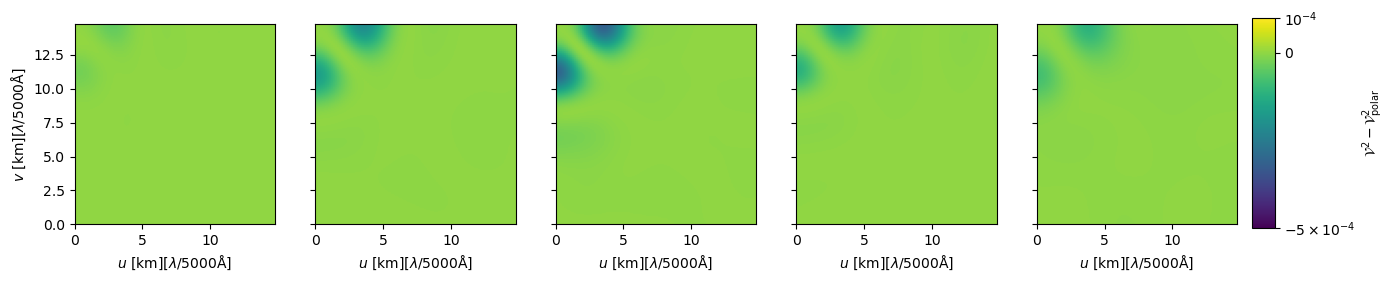

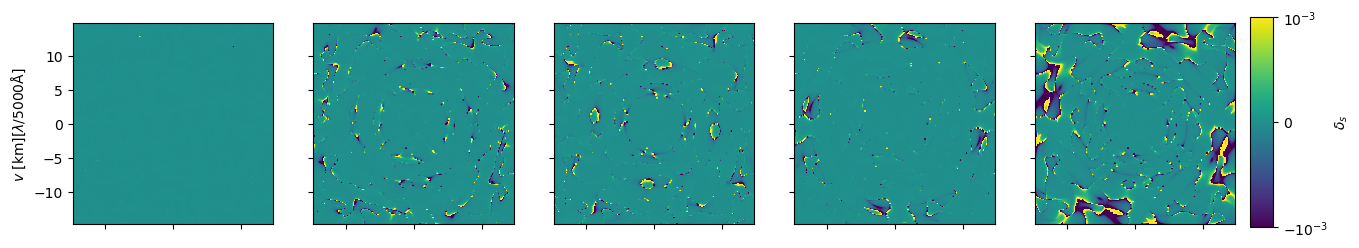

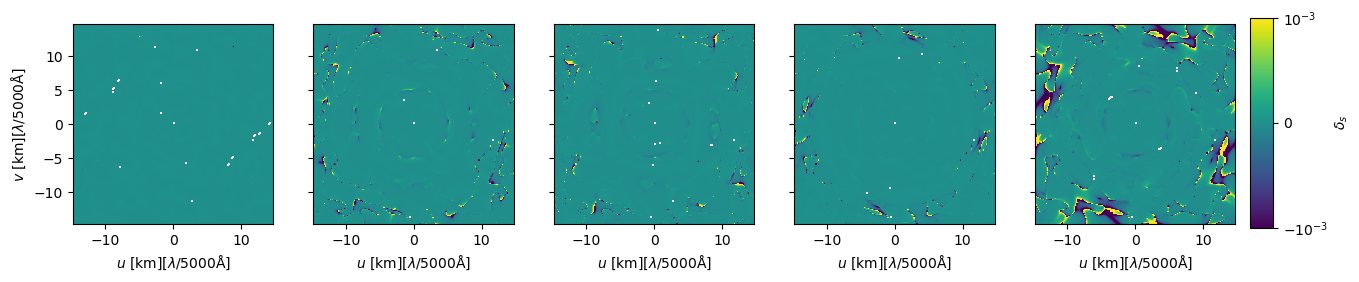

In [17]:
wls = [5850,6055,6128,6189,6355.12]
wls = [3700, 4700, 6055, 6355,8750]
wls = [3700, 4700, 6128, 6189,8750]

idxs = [ numpy.abs(wavegrid - l).argmin() for l in wls]
factor = 10

Dwidth = 2 * 32000*3600*24*20 * factor * units.km
DA = cosmo.angular_diameter_distance(0.004)
Deltau = (DA/Dwidth).decompose()*5000e-10/1000   #at 5000A km

fluxshape = flux[0,:,:].shape

paddedarray = numpy.zeros((fluxshape[0]*factor, fluxshape[1]*factor))
numpy.random.seed(42)
noisemap = numpy.random.normal(1,0.05,size=(fluxshape[0], fluxshape[1]))

# fig,axs = plt.subplots(4,5, figsize=(15, 12))
fig0,axs0 = plt.subplots(1,5, figsize=(15, 3))
# fig1,axs1 = plt.subplots(1,5, figsize=(15, 3))
fig2,axs2 = plt.subplots(1,5, figsize=(15, 3))
# fig3,axs3 = plt.subplots(1,5, figsize=(15, 3))
fig4,axs4 = plt.subplots(1,5, figsize=(15, 3))

# theta = numpy.arange(fluxshape[0]*factor)
theta  = [i- fluxshape[0]/2 + 0.5 for i in range(paddedarray.shape[0])]
theta = numpy.array(theta)

# Fsinv_phi = numpy.zeros((paddedarray.shape[0],paddedarray.shape[1]))
# Fsinv_s = numpy.zeros((paddedarray.shape[0],paddedarray.shape[1]))
for i, idx in enumerate(idxs):
    paddedarray[:]=0
    flux_norm = flux[idx,:,:]
    flux_norm = flux_norm/flux_norm.sum()
    paddedarray[0:fluxshape[0], 0:fluxshape[1]]= flux_norm
    gamma = jax.numpy.fft.fft2(paddedarray)
    gamma2  = jax.numpy.absolute(gamma)**2

    flux_norm = flux[idx,:,:]+Q[idx,:,:]
    flux_norm = flux_norm/flux_norm.sum()
    paddedarray[0:fluxshape[0], 0:fluxshape[1]]= flux_norm
    gamma = jax.numpy.fft.fft2(paddedarray)
    gamma2_p  = jax.numpy.absolute(gamma)**2

    flux_norm = flux[idx,:,:]-Q[idx,:,:]
    flux_norm = flux_norm/flux_norm.sum()
    paddedarray[0:fluxshape[0], 0:fluxshape[1]]= flux_norm
    gamma = jax.numpy.fft.fft2(paddedarray)
    gamma2_n  = jax.numpy.absolute(gamma)**2

    gamma2_polar = (gamma2_p+gamma2_n)/2

    diff = gamma2 - gamma2_polar

    minx = paddedarray.shape[0]//2-factor//3*fluxshape[0]
    maxx = paddedarray.shape[0]//2+factor//3*fluxshape[0]

    emin = minx - (minx + maxx)/2
    emax = maxx - (minx + maxx)/2
    
    im0 = axs0[i].imshow(diff[0:fluxshape[0]*factor//2,0:fluxshape[1]*factor//2],
                         norm=matplotlib.colors.SymLogNorm(linthresh=0.03, linscale=0.03,
                                              vmin=-0.0005, vmax=0.0001, base=10),
                         extent=[0,emax*Deltau,0,emax*Deltau])
    if i ==0:
        axs0[i].set_ylabel(r'$v$ [km][$\lambda/5000$Å]')
    axs0[i].set_xlabel(r'$u$ [km][$\lambda/5000$Å]')
    if i != 0:
        axs0[i].yaxis.set_ticklabels([])
    # axs0[i].xaxis.set_ticklabels([])
    # axs0[i].yaxis.set_ticklabels([])
    # axs0[i].set_title(r'$\lambda={:.2f}$Å'.format(wavegrid[idx]))    
    
    u=fftfreq(paddedarray.shape[0])
    v=fftfreq(paddedarray.shape[1])
    
    dgammas = -(u[:,None]*dgammau + v[None,:]*dgammav)
    dgammaphi = -v[None,:]*dgammau + u[:,None]*dgammav
    
    F00= jax.numpy.absolute(2*gamma.conjugate() * dgammas) **2
    F01= jax.numpy.absolute(2*gamma.conjugate() * dgammas)*jax.numpy.absolute(2*gamma.conjugate() * dgammaphi)
    F11 = jax.numpy.absolute(2*gamma.conjugate() * dgammaphi)**2

    gamma2 = numpy.fft.fftshift(gamma2)
    gamma2_polar = numpy.fft.fftshift(gamma2_polar)

    Deltagamma2 = gamma2 - gamma2_polar

    F00 = numpy.fft.fftshift(F00)
    F01 = numpy.fft.fftshift(F01)
    F11 = numpy.fft.fftshift(F11)    

    gamma2rot = numpy.rot90(gamma2)    
    Deltagamma2rot = numpy.rot90(Deltagamma2)
    F00rot=numpy.rot90(F00)
    F01rot=numpy.rot90(F01)
    F11rot=numpy.rot90(F11)

    gamma2rot45 = numpy.pad(scipy.ndimage.rotate(scipy.ndimage.zoom(gamma2,1/numpy.sqrt(2)),45,reshape=True),((0,1),(0,1))) 
    Deltagamma2rot45 = numpy.pad(scipy.ndimage.rotate(scipy.ndimage.zoom(Deltagamma2,1/numpy.sqrt(2)),45,reshape=True),((0,1),(0,1))) 

    F00rot45 = numpy.pad(scipy.ndimage.rotate(scipy.ndimage.zoom(F00,1/numpy.sqrt(2)),45,reshape=True),((0,1),(0,1)))
    F01rot45 = numpy.pad(scipy.ndimage.rotate(scipy.ndimage.zoom(F01,1/numpy.sqrt(2)),45,reshape=True),((0,1),(0,1)))
    F11rot45 = numpy.pad(scipy.ndimage.rotate(scipy.ndimage.zoom(F11,1/numpy.sqrt(2)),45,reshape=True),((0,1),(0,1)))
    
    siginv = dGammadnu[idx] * (128*numpy.pi)**(-0.25) * numpy.sqrt(3600/sigma_t)
    
    for ui in range(0,Fsinv.shape[0]):
        for vi in range(0,Fsinv.shape[1]):
            if ui==0 and vi==0:
                continue
            try:
                Finv = numpy.linalg.inv([[F00[ui,vi]+F00rot[ui,vi],F01[ui,vi]+F01rot[ui,vi]],[F01[ui,vi]+F01rot[ui,vi],F11[ui,vi]+F11rot[ui,vi]]])
                Fsinv[ui,vi] = Finv[0,0]
                deltas[ui,vi] = (Finv[0,0]* siginv**2 /2 *
                                    (numpy.sqrt(F00[ui,vi]) * Deltagamma2[ui,vi] +
                                     numpy.sqrt(F00rot[ui,vi]) * Deltagamma2rot[ui,vi]
                                    ) + 
                                Finv[0,1]* siginv**2 /2 *
                                     (numpy.sqrt(F11[ui,vi]) * Deltagamma2[ui,vi] +
                                     numpy.sqrt(F11rot[ui,vi]) * Deltagamma2rot[ui,vi])
                                 )
                Finv = numpy.linalg.inv(
                    [[F00[ui,vi]+F00rot[ui,vi]+F00rot45[ui,vi],F01[ui,vi]+F01rot[ui,vi]+F01rot45[ui,vi]],
                     [F01[ui,vi]+F01rot[ui,vi]+F01rot45[ui,vi],F11[ui,vi]+F11rot[ui,vi]+F11rot45[ui,vi]]]
                     )
                Fsinv45[ui,vi] = Finv[0,0]
                deltas45[ui,vi] = (Finv[0,0]* siginv**2 /3 *
                                    (numpy.sqrt(F00[ui,vi]) * Deltagamma2[ui,vi] +
                                     numpy.sqrt(F00rot[ui,vi]) * Deltagamma2rot[ui,vi] +
                                     numpy.sqrt(F00rot45[ui,vi]) * Deltagamma2rot45[ui,vi] 
                                    ) + 
                                Finv[0,1]* siginv**2 /3 *
                                     (numpy.sqrt(F11[ui,vi]) * Deltagamma2[ui,vi] +
                                     numpy.sqrt(F11rot[ui,vi]) * Deltagamma2rot[ui,vi] +
                                     numpy.sqrt(F11rot45[ui,vi]) * Deltagamma2rot45[ui,vi])
                                 )
            except:
                pass

    # im1 = axs1[i].imshow(siginv /2 *
    #                      numpy.sqrt(1/Fsinv[minx:maxx,minx:maxx]),
    #                      norm='log',vmin=0.01,vmax=0.5,extent=[emin*Deltau,emax*Deltau,emin*Deltau,emax*Deltau])
    
    # if i ==0:
    #     axs1[i].set_ylabel(r'$v [km][$\lambda/5000$Å]$')
    # # axs1[i].set_xlabel(r'$u$ [km][$\lambda/5000\AA$]')
    # axs1[i].xaxis.set_ticklabels([])
    # if i != 0:
    #     axs1[i].yaxis.set_ticklabels([])
    # axs1[i].set_title(r'$\lambda={:.2f}$Å'.format(wavegrid[idx]))

    im2 = axs2[i].imshow(deltas,norm=matplotlib.colors.SymLogNorm(linthresh=0.03, linscale=0.03,
                                              vmin=-0.001, vmax=0.001, base=10),
                         extent=[emin*Deltau,emax*Deltau,emin*Deltau,emax*Deltau])
    if i ==0:
        axs2[i].set_ylabel(r'$v$ [km][$\lambda/5000$Å]')
    # axs2[i].set_xlabel(r'$u$ [km][$\lambda/5000\AA$]')
    axs2[i].xaxis.set_ticklabels([])
    if i != 0:
        axs2[i].yaxis.set_ticklabels([])
    # axs[2,i].set_title(r'$\lambda={:.2f}\AA$'.format(wavegrid[idx]))
    
    # im3 = axs3[i].imshow(siginv /3 *
    #                     numpy.sqrt(1/Fsinv45[minx:maxx,minx:maxx]),norm='log',vmin=0.01,vmax=0.5,
    #                      extent=[emin*Deltau,emax*Deltau,emin*Deltau,emax*Deltau])

    
    # if i ==0:
    #     axs3[i].set_ylabel(r'$v$ [km][$\lambda/5000$Å]')
    # # axs3[i].set_xlabel(r'$u$ [km][$\lambda/5000\AA$]')
    # axs3[i].xaxis.set_ticklabels([])
    # if i != 0:
    #     axs3[i].yaxis.set_ticklabels([])
    # # axs[3,i].set_title(r'$\lambda={:.2f}\AA$'.format(wavegrid[idx]))
    
    im4 = axs4[i].imshow(deltas45,norm=matplotlib.colors.SymLogNorm(linthresh=0.03, linscale=0.03,
                                              vmin=-0.001, vmax=0.001, base=10),
                         extent=[emin*Deltau,emax*Deltau,emin*Deltau,emax*Deltau])
    if i ==0:
        axs4[i].set_ylabel(r'$v$ [km][$\lambda/5000$Å]')
    axs4[i].set_xlabel(r'$u$ [km][$\lambda/5000$Å]')
    if i != 0:
        axs4[i].yaxis.set_ticklabels([])
    # axs[4,i].set_title(r'$\lambda={:.2f}\AA$'.format(wavegrid[idx]))
    
fig0.subplots_adjust(right=0.90)
# fig1.subplots_adjust(right=0.90)
fig2.subplots_adjust(right=0.90)
# fig3.subplots_adjust(right=0.90)
fig4.subplots_adjust(right=0.90)
# cbar_ax = fig0.add_axes([0.91, 0.15, 0.015, 0.7])
# cbar=fig0.colorbar(im0, cax=cbar_ax)
# cbar.set_label(r"$\mathcal{V}^2$")
# cbar_ax = fig1.add_axes([0.91, 0.15, 0.015, 0.7])
# cbar=fig1.colorbar(im1, cax=cbar_ax)
# cbar.set_label(r"$SNR_s$")
cbar_ax = fig2.add_axes([0.91, 0.15, 0.015, 0.7])
cbar=fig2.colorbar(im2, cax=cbar_ax)
cbar.set_label(r"$\delta_s$")
# cbar_ax = fig3.add_axes([0.91, 0.15, 0.015, 0.7])
# cbar=fig3.colorbar(im3, cax=cbar_ax)
# cbar.set_label(r"$SNR_s$")
cbar_ax = fig4.add_axes([0.91, 0.15, 0.015, 0.7])
cbar=fig4.colorbar(im4, cax=cbar_ax)
cbar.set_label(r"$\delta_s$")    
# fig0.subplots_adjust(right=0.90)

cbar_ax = fig0.add_axes([0.91, 0.15, 0.015, 0.7])
cbar=fig0.colorbar(im0, cax=cbar_ax)
cbar.set_label(r"$\mathcal{V}^2 - \mathcal{V}^2_\text{polar}$")

fig0.savefig('g2mapdiffP_sedona.pdf')
fig2.savefig('ds_p_1_sedona.pdf')
fig4.savefig('ds_p_2_sedona.pdf')



/var/folders/hr/9sdqv6450z16rzwk76fgsygw0000gn/T/ipykernel_12038/114041702.py:136: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(F11rot45[ui,vi]) * Deltagamma2rot45[ui,vi])
/var/folders/hr/9sdqv6450z16rzwk76fgsygw0000gn/T/ipykernel_12038/114041702.py:131: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(F00rot45[ui,vi]) * Deltagamma2rot45[ui,vi]
/var/folders/hr/9sdqv6450z16rzwk76fgsygw0000gn/T/ipykernel_12038/114041702.py:136: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(F11rot45[ui,vi]) * Deltagamma2rot45[ui,vi])
/var/folders/hr/9sdqv6450z16rzwk76fgsygw0000gn/T/ipykernel_12038/114041702.py:131: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(F00rot45[ui,vi]) * Deltagamma2rot45[ui,vi]
/var/folders/hr/9sdqv6450z16rzwk76fgsygw0000gn/T/ipykernel_12038/114041702.py:136: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(F11rot45[ui,vi]) * Deltagamma2rot45[ui,vi])
/var/folders/hr/9sdqv6450z16rzwk76fgsygw0000gn/T/ipy

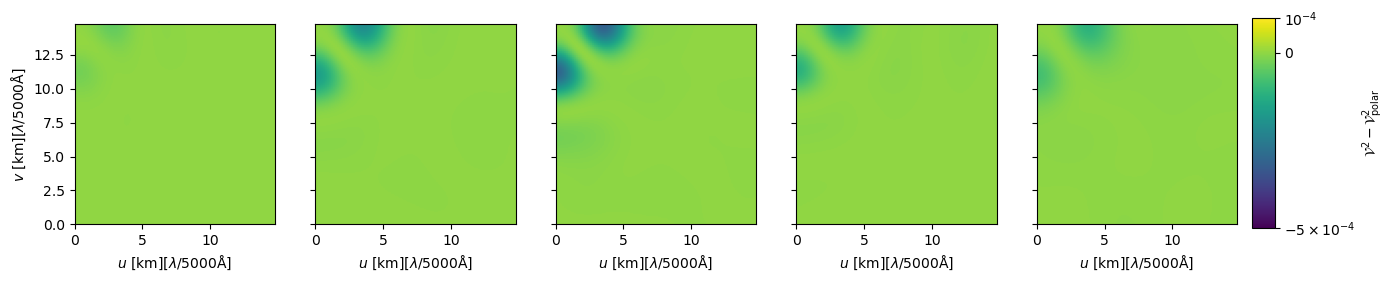

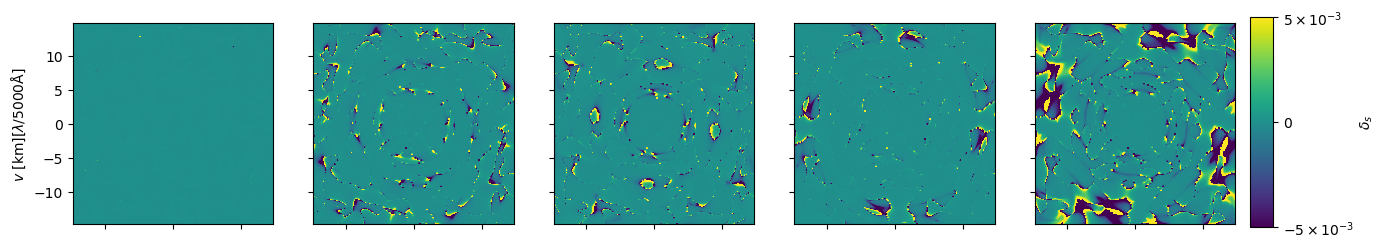

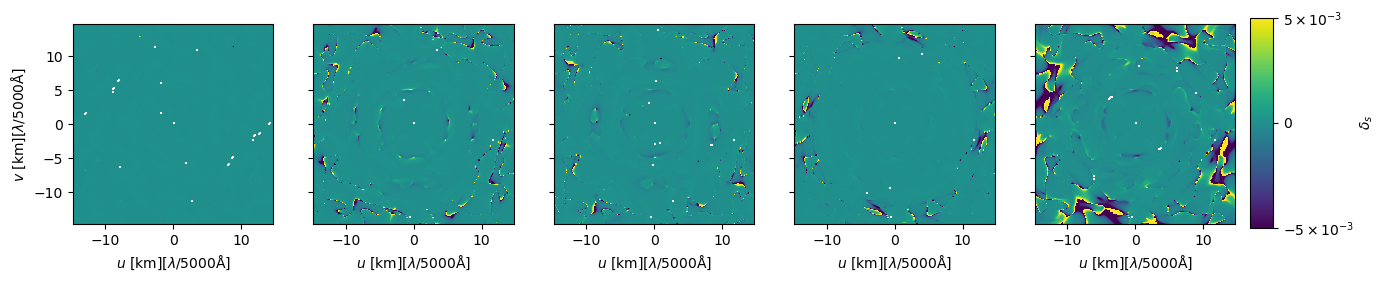

In [85]:
F00.shape

(200, 200)

In [86]:
scipy.ndimage.zoom(F00,1/numpy.sqrt(2)).shape

(141, 141)

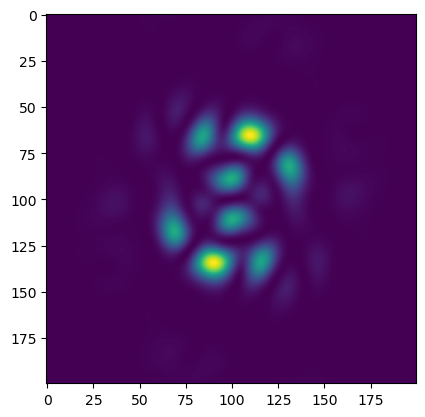

In [88]:
plt.imshow(F11)

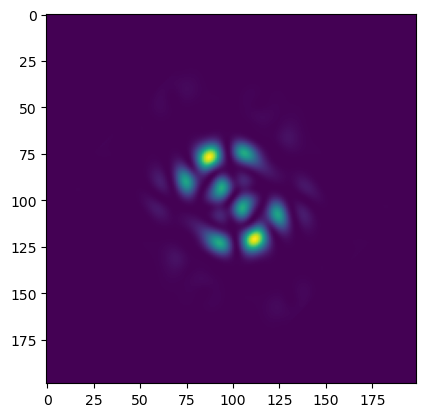

In [92]:
plt.imshow(scipy.ndimage.rotate(scipy.ndimage.zoom(F11,1/numpy.sqrt(2)),45,reshape=True))

In [96]:
numpy.pad(scipy.ndimage.rotate(scipy.ndimage.zoom(F11,1/numpy.sqrt(2)),45,reshape=True),((0,1),(0,1))).shape

(200, 200)